In [ ]:
from queue import PriorityQueue
import matplotlib.pyplot as plt
from scipy.stats import t
import seaborn as sns
import numpy as np
import random
import time

In [ ]:
class Measure_plot:
  def __init__(self):
    self.avg_time = []   #average time for a client to cross the queue
    self.ci_time = []    #confidence interval time
    self.avg_cl = []    #average number of client in the queue
    self.ci_cl = []     #confidence interval client
    self.ut = []     #utilization
    self.ci_ut = []  #confidence interval utilization
    self.loss = []   #probabiliti to lose a client
    self.ci_loss = []  #confidence interval loss
  
  def set_avg_time(self, avg, ci):
    self.avg_time.append(avg)
    self.ci_time.append(ci)
    return

  def set_avg_cl(self, avg, ci):
    self.avg_cl.append(avg)
    self.ci_cl.append(ci)
    return
  
  def set_ut(self, ut, ci):
    self.ut.append(ut)
    self.ci_ut.append(ci)
    return

  def set_loss(self, loss, ci):
    self.loss.append(loss)
    self.ci_loss.append(ci)
    return

  def get_avg_time(self):
    return self.avg_time, self.ci_time

  def get_avg_cl(self):
    return self.avg_cl, self.ci_cl
  
  def get_ut(self):
    return self.ut, self.ci_ut

  def get_loss(self):
    return self.loss, self.ci_loss

In [ ]:
def conf_int(vect, cl, N_runs):
  mean = np.mean(vect)
  var = np.var(vect, ddof=1)
  if var == 0:
    ci = (mean, mean)
  else:
    ci = t.interval(cl, N_runs-1, mean, np.sqrt(var/N_runs))

  return ci, mean

In [ ]:
class Client:
  def __init__(self, arrival_time):
    self.arrival_time = arrival_time
    self.depart_time = -1

  def served(self, depart_time):
    self.depart_time = depart_time
    return
  
  def get_arrival_time(self):
    return self.arrival_time

  def get_depart_time(self):
    return self.depart_time

#Task1 M/M/1 and M/G/1 queue

In [ ]:
class Server():
  def __init__(self,  id=-1, mu=-1, type_s='M', a=-1, b=-1):
    if type_s == 'M':
      if mu<= 0: 
        print("Wrong parameter!")
        return
      self.mu = mu  #mu for the service rate
    elif type_s == 'U':
      if b<=a:
        print("Wrong interval!")
        return
      self.a = a   #bounds for the uniform distributions
      self.b = b
    else:
      print('Error wrong type of service rate')
      return

    self.type_s = type_s
    self.id = id
    self.N_served = 0 #count of people served by that server

  def get_N_served(self):
    return self.N_served

  def serve(self, time, FES):  
    self.N_served += 1
    if self.type_s == 'M':
      service_time = random.expovariate(self.mu)
    elif self.type_s == 'U':
      service_time = random.uniform(self.a, self.b)

    FES.put((time + service_time, "D")) #add a departure in the FES
    return service_time

In [ ]:
class My_queue():
  def __init__(self, type_a='', l=-1, a=-1, b=-1): 
    self.N_arr = 0
    self.N_dep = 0
    self.oldT = 0
    self.avg_cl = 0
    self.avg_delay = 0
    self.clients = []
    
    if type_a == 'M':
      if l<= 0: 
        print("Wrong parameter!")
        return
      self.l = l  #lambda for the arrival rate
    elif type_a == 'U':
      if b<=a:
        print("Wrong interval!")
        return
      self.a = a   #bounds for the uniform distributions
      self.b = b
    else:
      print('Error wrong type of arrival in the queue')
    self.type_a = type_a
  
  def get_N_arr(self):
    return self.N_arr

  def get_N_dep(self):
    return self.N_dep

  def get_avg_cl(self, time):
    return self.avg_cl/time

  def arrival(self, time, FES):
    global N_user  
    
    self.N_arr += 1   #update total number of arrival
    self.avg_cl += N_user*(time-self.oldT)
    self.oldT = time  #update previous time
    
    N_user += 1 #update the state variable
    client = Client(time) #record for the client that arrive in the actual time
    self.clients.append(client) 

    if self.type_a == 'M':
      inter_arrival = random.expovariate(self.l)
    elif self.type_a == 'U':
      inter_arrival = random.uniform(self.a, self.b)
    FES.put((time + inter_arrival, "A"))  #schedule the next arrival
    return

  def departure(self, time):
    global N_user 

    client = self.clients.pop(0)
    self.N_dep += 1
    self.avg_cl += N_user*(time-self.oldT)
    self.oldT = time

    client.served(time)
    N_user -= 1  #update the state variable
    return client

In [ ]:
def simulate(Max_time=100, type_a='M', type_s='M', mu=0, l=0, a_q=0, b_q=0, a_s=0, b_s=0):
  global N_user 
  N_user = 0      #state variable
  time = 0
  free_time = 0   #number of client that find a free server
  avg_delay = 0   #average tyme to cross the queue
  FES = PriorityQueue() # Future Event Set
  FES.put((0, "A")) #first event

  my_queue = My_queue(l=l, type_a=type_a, a=a_q, b=b_q)
  server = Server(id=0, mu=mu, type_s=type_s, a=a_s, b=b_s)

  while time < Max_time:
    (time, event_type) = FES.get()
    if event_type == "A":
      my_queue.arrival(time,FES)
      if N_user == 1: #the queue was empty
        server.serve(time, FES) #schedule the  departure of the client
        free_time += 1
    elif event_type == "D":
      client = my_queue.departure(time) #the client leave the queue
      avg_delay += (client.get_depart_time()-client.get_arrival_time()) #cumulative delay
      if N_user > 0: #other people in the queue 
        service_duration = server.serve(time, FES)

  avg_cl = my_queue.get_avg_cl(time)
  avg_delay = avg_delay/my_queue.get_N_dep()
  ut = 1-(free_time/my_queue.get_N_arr())
  return avg_cl, avg_delay, ut

##Simulation for the M/M/1

In [ ]:
N_runs = 15  #Number of runs
seed = 1   #initial seed
cl = 0.95  #confidence level

Max_time = 604800 #1 week
avg_service_time = 30  #seconds
mu = 1/avg_service_time   #mu for the service time
mm1_measure_simulation = Measure_plot()
mm1_measure_theory = Measure_plot()
LOADS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.925, 0.95, 0.975, 0.99]

In [ ]:
print("Start simulation for the M/M/1 queue")
for load in LOADS:
  print(f"The load on the queue is: {load}")
  l = load/avg_service_time #lambda for the arrival process
  seed = 1
  #compute the theoretical value
  ro = l/mu
  E_n = ro/(1-ro)
  E_t = E_n/l
  Avg_N_clients = []
  Avg_delay = []
  Utilizations = []
  for i in range(N_runs):
    print(f'Run number: {i}')
    random.seed(seed)
    avg_cl, avg_d, ut = simulate(Max_time=Max_time, type_a='M', type_s='M', mu=mu, l=l)
    Avg_N_clients.append(avg_cl)
    Avg_delay.append(avg_d)
    Utilizations.append(ut)
    seed += 1

  ci_avg_cl, avg_cl = conf_int(Avg_N_clients, cl, N_runs)
  mm1_measure_simulation.set_avg_cl(avg_cl, ci_avg_cl)
  mm1_measure_theory.set_avg_cl(E_n, 0)

  ci_avg_d, avg_d = conf_int(Avg_delay, cl, N_runs)
  mm1_measure_simulation.set_avg_time(avg_d, ci_avg_d)
  mm1_measure_theory.set_avg_time(E_t, 0)

  ci_ut, ut = conf_int(Utilizations, cl, N_runs)
  mm1_measure_simulation.set_ut(ut, ci_ut)
  mm1_measure_theory.set_ut(ro, 0)

Start simulation for the M/M/1 queue
The load on the queue is: 0.1
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
The load on the queue is: 0.2
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
The load on the queue is: 0.3
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
The load on the queue is: 0.4
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 1

In [ ]:
#one single run
global N_user 
N_user = 0  #state variable
time = 0    #initil time
free_time = 0

load = 0.6
avg_service_time = 30  #seconds
l = load/avg_service_time #lambda for the arrival process
mu = 1/avg_service_time   #mu for the service time

my_queue = My_queue(l=l, type_a='M')
server = Server(id=0 , mu=mu)
all_client = []
FES = PriorityQueue() # Future Event Set
FES.put((0, "A")) #first event
Max_time = 7200 #2 hour
avg_delay = 0
oldT = 0

In [ ]:
random.seed(1)
while time < Max_time:
  (time, event_type) = FES.get()
  if event_type == "A":
    my_queue.arrival(time,FES)
    if N_user == 1: #the queue was empty
      free_time += 1  #schedule the departure
      server.serve(time, FES)
  
  elif event_type == "D":
    client = my_queue.departure(time)
    avg_delay += (client.get_depart_time()-client.get_arrival_time())
    if N_user > 0: #other people in the queue 
        service_duration = server.serve(time, FES)
  
  all_client.append((N_user,oldT,time)) 
  oldT = time

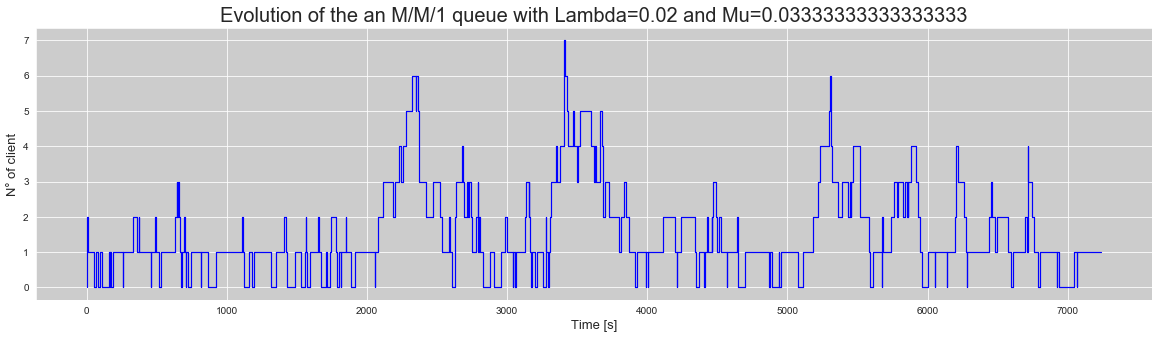

In [ ]:
#plotting
sns.set_palette("colorblind")        
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})

fig, ax = plt.subplots(figsize=(20,5))
old_c = 0
for c in all_client:  
  ax.plot([c[1],c[2]], [c[0],c[0]], linewidth=1.2, c='b')
  ax.plot([c[1],c[1]], [old_c, c[0]], linewidth=1.2, c='b')#, label='qui')
  old_c = c[0]

ax.set_xlabel("Time [s]", fontsize=13)
ax.set_ylabel("N° of client", fontsize=13) 
plt.title(f"Evolution of the an M/M/1 queue with Lambda={l} and Mu={mu}", fontsize=20)
plt.show()

##Simulation for the M/G/1

In [ ]:
N_runs = 15 #Number of runs
seed = 1    #initial seed
cl = 0.95   #confidence level

Max_time = 604800  #one week
a = 1
b = 59  #intervall for the service time
avg_sevice_time = (b+a)/2
mg1_measure_simulation = Measure_plot()
mg1_measure_theory = Measure_plot()
LOADS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.925, 0.95, 0.975, 0.99]

In [ ]:
print("Start simulation for the M/G/1 queue")
for load in LOADS:
  print(f"The load on the queue is: {load}")
  l = load/avg_service_time #lambda for the arrival process
  seed = 1
  #compute the theoretical value
  E_s = ((a+b)/2)  #mean time the server is busy 
  Var_s = (1/12) * np.power((b-a),2)      
  C_s = Var_s/(E_s*E_s)
  ro = l*E_s
  E_n = ro + (ro*ro)*((1+C_s)/(2*(1-ro)))
  E_t = E_s + ro*E_s*((1+C_s)/(2*(1-ro)))

  Avg_N_clients = []
  Avg_delay = []
  Utilizations = []
  for i in range(N_runs):
    print(f'Run number: {i}')
    random.seed(seed)
    avg_cl, avg_d, ut = simulate(Max_time=Max_time, type_a='M', type_s='U', a_s=a, b_s=b, l=l)
    Avg_N_clients.append(avg_cl)
    Avg_delay.append(avg_d)
    Utilizations.append(ut)
    seed += 1

  ci_avg_cl, avg_cl = conf_int(Avg_N_clients, cl, N_runs)
  mg1_measure_simulation.set_avg_cl(avg_cl, ci_avg_cl)
  mg1_measure_theory.set_avg_cl(E_n, 0)

  ci_avg_d, avg_d = conf_int(Avg_delay, cl, N_runs)
  mg1_measure_simulation.set_avg_time(avg_d, ci_avg_d)
  mg1_measure_theory.set_avg_time(E_t, 0)

  ci_ut, ut = conf_int(Utilizations, cl, N_runs)
  mg1_measure_simulation.set_ut(ut, ci_ut)
  mg1_measure_theory.set_ut(ro, 0)

Start simulation for the M/G/1 queue
The load on the queue is: 0.1
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
The load on the queue is: 0.2
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
The load on the queue is: 0.3
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
The load on the queue is: 0.4
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 1

In [ ]:
#one single run
global N_user 
N_user = 0  #state variable
time = 0    #initil time
free_time = 0

load = 0.6
a = 1
b = 59  #intervall for the service time
avg_sevice_time = (b+a)/2
l = load/avg_sevice_time  #lambda for the arrival process

my_queue = My_queue(l=l, type_a='M')
server = Server(id=0, a=a, b=b, type_s='U')
all_client = []
FES = PriorityQueue() # Future Event Set
FES.put((0, "A")) #first event
Max_time = 7200 #2 hour
avg_delay = 0
oldT = 0

In [ ]:
random.seed(1)
while time < Max_time:
  (time, event_type) = FES.get()
  if event_type == "A":
    my_queue.arrival(time,FES)
    if N_user == 1: #the queue was empty
      free_time += 1  #schedule the departure
      server.serve(time, FES)

  elif event_type == "D":
    client = my_queue.departure(time)
    avg_delay += (client.get_depart_time()-client.get_arrival_time())
    if N_user > 0: #other people in the queue 
        service_duration = server.serve(time, FES)
  
  all_client.append((N_user,oldT,time)) 
  oldT = time

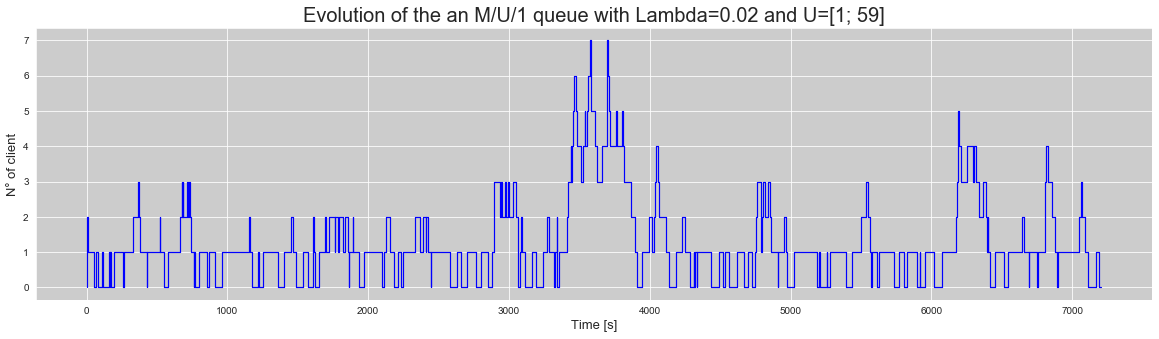

In [ ]:
#plotting
sns.set_palette("colorblind")  
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})

fig, ax = plt.subplots(figsize=(20,5))
old_c = 0
for c in all_client:
  ax.plot([c[1],c[2]], [c[0],c[0]], linewidth=1.2, c='b')
  ax.plot([c[1],c[1]], [old_c, c[0]], linewidth=1.2, c='b')
  old_c = c[0]

ax.set_xlabel("Time [s]", fontsize=13)
ax.set_ylabel("N° of client", fontsize=13) 
plt.title(f"Evolution of the an M/U/1 queue with Lambda={l} and U=[{a}; {b}]", fontsize=20)
plt.show()

## Plotting

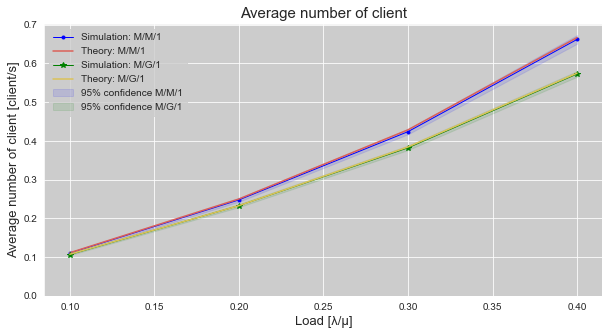

In [ ]:
#average client
#M/M/1
LW_ci = []
UP_ci = []
avg_cl, ci_s = mm1_measure_simulation.get_avg_cl() 
avg_t, _ = mm1_measure_theory.get_avg_cl()
for i in range(len(LOADS)):
  LW_ci.append(ci_s[i][0])
  UP_ci.append(ci_s[i][1])

sns.set_palette("hls", 8)
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(LOADS, avg_cl, label='Simulation: M/M/1', color='b', linewidth=1, alpha = 1, marker='.')
ax.plot(LOADS, avg_t, label ='Theory: M/M/1')
ax.fill_between(LOADS, LW_ci, UP_ci, color='b', alpha=.1, label="95% confidence M/M/1")

#M/G/1
LW_ci = []
UP_ci = []
avg_cl, ci_s = mg1_measure_simulation.get_avg_cl() 
avg_t, _ = mg1_measure_theory.get_avg_cl()
for i in range(len(LOADS)):
  LW_ci.append(ci_s[i][0])
  UP_ci.append(ci_s[i][1])

ax.plot(LOADS, avg_cl, label='Simulation: M/G/1',linewidth=1, color='g', alpha = 1, marker='*')
ax.plot(LOADS, avg_t, label ='Theory: M/G/1')
ax.fill_between(LOADS, LW_ci, UP_ci, color='g', alpha=.1, label="95% confidence M/G/1")

ax.set_ylim(ymin=0)
ax.set_xlabel("Load [\u03BB/\u03BC]", fontsize=13)
ax.set_ylabel("Average number of client [client/s]", fontsize=13) #controllare unità di misura
ax.legend()
plt.title(f"Average number of client", fontsize=15)
plt.show()

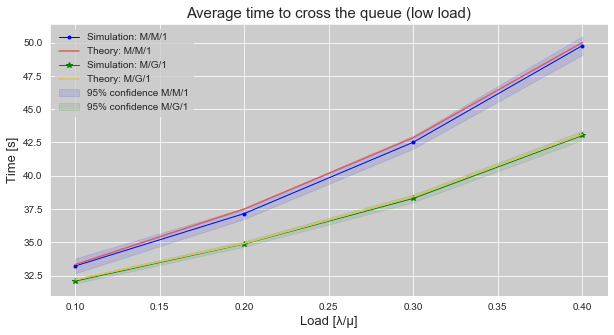

In [ ]:
#average time
LW_ci = []
UP_ci = []
avg_cl, ci_s = mm1_measure_simulation.get_avg_time() 
avg_t, _ = mm1_measure_theory.get_avg_time()
for i in range(len(LOADS)):
  LW_ci.append(ci_s[i][0])
  UP_ci.append(ci_s[i][1])

sns.set_palette("hls", 8)
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(LOADS, avg_cl, label='Simulation: M/M/1',linewidth=1, color='b', alpha = 1, marker='.')
ax.plot(LOADS, avg_t, label ='Theory: M/M/1')
ax.fill_between(LOADS, LW_ci, UP_ci, color='b', alpha=.1, label="95% confidence M/M/1")

#M/G/1
LW_ci = []
UP_ci = []
avg_cl, ci_s = mg1_measure_simulation.get_avg_time() 
avg_t, _ = mg1_measure_theory.get_avg_time()
for i in range(len(LOADS)):
  LW_ci.append(ci_s[i][0])
  UP_ci.append(ci_s[i][1])

ax.plot(LOADS, avg_cl, label='Simulation: M/G/1',linewidth=1, color='g',  alpha = 1, marker='*')
ax.plot(LOADS, avg_t, label ='Theory: M/G/1')
ax.fill_between(LOADS, LW_ci, UP_ci, color='g', alpha=.1, label="95% confidence M/G/1")

ax.set_ylim(ymin=0)
ax.set_xlabel("Load [\u03BB/\u03BC]", fontsize=13)
ax.set_ylabel("Time [s]", fontsize=13) #controllare unità di misura
ax.legend()
plt.title(f"Average time to cross the queue", fontsize=15)
plt.show()

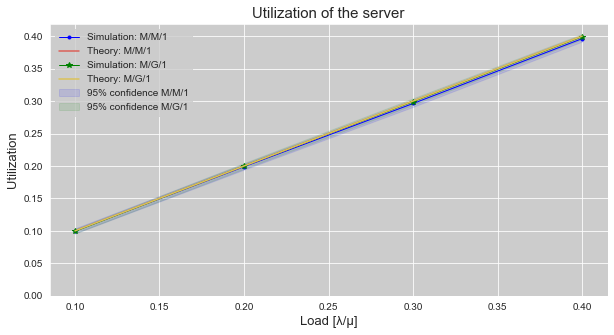

In [ ]:
#average utilization
#M/M/1
LW_ci = []
UP_ci = []
avg_cl, ci_s = mm1_measure_simulation.get_ut() 
avg_t, _ = mm1_measure_theory.get_ut()
for i in range(len(LOADS)):
  LW_ci.append(ci_s[i][0])
  UP_ci.append(ci_s[i][1])

sns.set_palette("hls", 8)
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(LOADS, avg_cl, label='Simulation: M/M/1',linewidth=1, color='b', alpha = 1, marker='.')
ax.plot(LOADS, avg_t, label ='Theory: M/M/1')
ax.fill_between(LOADS, LW_ci, UP_ci, color='b', alpha=.1, label="95% confidence M/M/1")

#M/G/1
LW_ci = []
UP_ci = []
avg_cl, ci_s = mg1_measure_simulation.get_ut() 
avg_t, _ = mg1_measure_theory.get_ut()
for i in range(len(LOADS)):
  LW_ci.append(ci_s[i][0])
  UP_ci.append(ci_s[i][1])

ax.plot(LOADS, avg_cl, label='Simulation: M/G/1',linewidth=1, color='g', alpha = 1, marker='*')
ax.plot(LOADS, avg_t, label ='Theory: M/G/1')
ax.fill_between(LOADS, LW_ci, UP_ci, color='g', alpha=.1, label="95% confidence M/G/1")

ax.set_ylim(ymin=0)
ax.set_xlabel("Load [\u03BB/\u03BC]", fontsize=13)
ax.set_ylabel("Utilization", fontsize=13) 
ax.legend()
plt.title(f"Utilization of the server", fontsize=15)
plt.show()

#Task2 M/M/1/B and M/G/1/B



In [ ]:
#re-define the queue class to manage the limit on the capacity of the waiting line
class My_queue():
  def __init__(self, type_a='M', l=-1, a=-1, b=-1, B=5): 
    self.N_arr = 0
    self.N_dep = 0
    self.oldT = 0
    self.avg_cl = 0
    self.avg_delay = 0
    self.clients = []
    self.N_loss = 0

    if B<= 0:
      print("Wrong value for the  capacity!") 
      return
    self.B = B
    
    if type_a == 'M':
      if l<= 0: 
        print("Wrong parameter!")
        return
      self.l = l  #lambda for the arrival rate
    elif type_a == 'U':
      if b<=a:
        print("Wrong interval!")
        return
      self.a = a   #parameter for the uniform distributions
      self.b = b
    else:
      print('Error wrong type of arrival in the queue')
      return
    self.type_a = type_a
  
  def get_N_arr(self):
    return self.N_arr

  def get_N_dep(self):
    return self.N_dep

  def get_avg_cl(self, time):
    return self.avg_cl/time
  
  def get_N_loss(self):
    return self.N_loss

  def arrival(self, time, FES):
    global N_user 
    self.N_arr += 1   #update total number of arrival 
    if len(self.clients) < self.B:
      self.avg_cl += N_user*(time-self.oldT)
      self.oldT = time        #update previous time
      N_user += 1             #update the state variable
      client = Client(time)   #record for the client that arrive in the actual time
      self.clients.append(client) 
    else: #the client will be not served
      self.N_loss += 1

    if self.type_a == 'M':
      inter_arrival = random.expovariate(self.l)
    elif self.type_a == 'U':
      inter_arrival = random.uniform(self.a, self.b)
    FES.put((time + inter_arrival, "A"))  #Add the next arrival
    return

  def departure(self, time):#, FES, server):
    global N_user 

    client = self.clients.pop(0)
    self.N_dep += 1
    self.avg_cl += N_user*(time-self.oldT)
    self.oldT = time

    client.served(time)
    N_user -= 1  #update the state variable

    return client

In [ ]:
def simulate(Max_time=100, type_a='M', type_s='M', mu=0, l=0, a_q=0, b_q=0, a_s=0, b_s=0, B=5):
  global N_user 
  N_user = 0 #state variable
  old_N_user = N_user  # to manage the case with B = 1
  time = 0
  free_time = 0   #number of client that find a free server
  avg_delay = 0   #average tyme to cross the queue
  FES = PriorityQueue() # Future Event Set
  FES.put((0, "A")) #first event

  my_queue = My_queue(l=l, type_a=type_a, a=a_q, b=b_q, B=B)
  server = Server(id=0, mu=mu, type_s=type_s, a=a_s, b=b_s)

  while time < Max_time:
    (time, event_type) = FES.get()
    if event_type == "A":
      old_N_user = N_user 
      my_queue.arrival(time,FES)
      #case B=1: if there is a loss, no departure must be scheduled
      #but N_user will remain 1. 
      if N_user == 1 and old_N_user != N_user: #the queue was empty
        server.serve(time, FES)  #schedule the next departure
        free_time += 1

    elif event_type == "D":
      client = my_queue.departure(time)  #the client leave the queue
      avg_delay += (client.get_depart_time()-client.get_arrival_time())  #cumulative delay
      if N_user > 0: #other people in the queue 
        service_duration = server.serve(time, FES)

  avg_cl = my_queue.get_avg_cl(time)
  avg_delay = avg_delay/my_queue.get_N_dep()
  ut = 1-(free_time/my_queue.get_N_arr())
  los = my_queue.get_N_loss()
  arr = my_queue.get_N_arr()
  L = los/arr
  return avg_cl, avg_delay, ut, L

##Simulation for the M/M/1/B

In [ ]:
N_runs = 15  #Number of runs
seed = 1    #initial seed
cl = 0.95  #confidence level

Max_time = 604800 #1 week
load = 0.95
avg_service_time = 30 #s
l = load/avg_service_time #lambda for the arrival process
mu = 1/avg_service_time   #mu for the service time
Bs = 26 
ro = l/mu
mm1b_measure_simulation = Measure_plot()
mm1b_measure_theory = Measure_plot()

In [ ]:
print("Simulate for the M/M/1/B queue")
for B in range(1, Bs):
  print(f"B is: {B}")
  seed = 1
  #compute the theoretical value
  E_n = 0
  for i in range(1,B+1): #range arrive to B
    E_n += i*( (1-ro)/(1-np.power(ro, (B+1))) ) * np.power(ro, i)

  L_t = ( (1-ro)/(1-np.power(ro, (B+1))) ) * np.power(ro,B) #Pi_b
  E_t = E_n/(l - (l*L_t))

  Avg_N_clients = []
  Avg_delay = []
  Utilizations = []
  Loss = []
  for i in range(N_runs):
    print(f'Run number: {i}')
    random.seed(seed)
    avg_cl, avg_d, ut, L = simulate(Max_time=Max_time, type_a='M', type_s='M', mu=mu, l=l, B=B)
    Avg_N_clients.append(avg_cl)
    Avg_delay.append(avg_d)
    Utilizations.append(ut)
    Loss.append(L)
    seed += 1

  ci_avg_cl, avg_cl = conf_int(Avg_N_clients, cl, N_runs)
  mm1b_measure_simulation.set_avg_cl(avg_cl, ci_avg_cl)
  mm1b_measure_theory.set_avg_cl(E_n, 0)

  ci_avg_d, avg_d = conf_int(Avg_delay, cl, N_runs)
  mm1b_measure_simulation.set_avg_time(avg_d, ci_avg_d)
  mm1b_measure_theory.set_avg_time(E_t, 0)

  ci_ut, ut = conf_int(Utilizations, cl, N_runs)
  mm1b_measure_simulation.set_ut(ut, ci_ut)

  ci_L, L = conf_int(Loss, cl, N_runs)
  mm1b_measure_simulation.set_loss(L, ci_L)
  mm1b_measure_theory.set_loss(L_t, 0)

Simulate for the M/M/1/B queue
B is: 1
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
B is: 2
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
B is: 3
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
B is: 4
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
B is: 5
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4

In [ ]:
#one single run
global N_user 
N_user = 0  #state variable
old_N_user = N_user
time = 0    #initil time
free_time = 0

load = 0.9
avg_service_time = 30
l = load/avg_service_time #lambda for the arrival process
mu = 1/avg_service_time   #mu for the service time
B = 4
my_queue = My_queue(l=l, type_a='M', B=B)
server = Server(id=0, mu=mu, type_s='M')

all_client = []
FES = PriorityQueue() # Future Event Set
FES.put((0, "A")) #first event
Max_time = 7200 #2 hour
avg_delay = 0
oldT = 0

In [ ]:
random.seed(1)
while time < Max_time:
  (time, event_type) = FES.get()
  if event_type == "A":
    old_N_user = N_user
    my_queue.arrival(time,FES)
    if N_user == 1 and old_N_user != N_user: #the server is idle
      free_time += 1  #the server was free
      server.serve(time, FES)
  
  elif event_type == "D":
    client = my_queue.departure(time)
    avg_delay += (client.get_depart_time()-client.get_arrival_time())
    if N_user > 0: #other people in the queue 
        service_duration = server.serve(time, FES)
  
  all_client.append((N_user,oldT,time)) 
  oldT = time

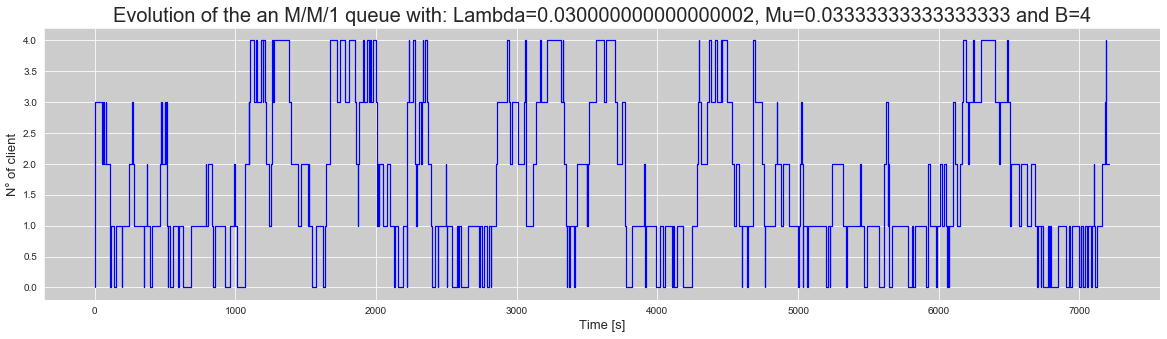

In [ ]:
#plotting
sns.set_palette("colorblind")        
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})

fig, ax = plt.subplots(figsize=(20,5))
old_c = 0
for c in all_client:  
  ax.plot([c[1],c[2]], [c[0],c[0]], linewidth=1.2, c='b')
  ax.plot([c[1],c[1]], [old_c, c[0]], linewidth=1.2, c='b')
  old_c = c[0]

ax.set_xlabel("Time [s]", fontsize=13)
ax.set_ylabel("N° of client", fontsize=13) 
plt.title(f"Evolution of the an M/M/1 queue with: Lambda={l}, Mu={mu} and B={B}", fontsize=20)
plt.show()

##Simulation for the M/G/1/B

In [ ]:
N_runs = 15  #Number of runs
seed = 1   #initial seed
cl = 0.95  #confidence level

Max_time = 604800
load = 0.95
a = 1
b = 59  #intervall for the service time
avg_sevice_time = (b+a)/2
l = load/avg_sevice_time  #lambda for the arrival process
Bs = 26 
mg1b_measure_simulation = Measure_plot()

In [ ]:
print("Simulate for the M/G/1/B queue")
for B in range(1, Bs):
  print(f"B is: {B}")
  seed = 1
  Avg_N_clients = []
  Avg_delay = []
  Utilizations = []
  Loss = []
  for i in range(N_runs):
    print(f'Run number: {i}')
    random.seed(seed)
    avg_cl, avg_d, ut, L = simulate(Max_time=Max_time, type_a='M', type_s='U', a_s=a, b_s=b, l=l, B=B)
    Avg_N_clients.append(avg_cl)
    Avg_delay.append(avg_d)
    Utilizations.append(ut)
    Loss.append(L)
    seed += 1

  ci_avg_cl, avg_cl = conf_int(Avg_N_clients, cl, N_runs)
  mg1b_measure_simulation.set_avg_cl(avg_cl, ci_avg_cl)

  ci_avg_d, avg_d = conf_int(Avg_delay, cl, N_runs)
  mg1b_measure_simulation.set_avg_time(avg_d, ci_avg_d)

  ci_ut, ut = conf_int(Utilizations, cl, N_runs)
  mg1b_measure_simulation.set_ut(ut, ci_ut)

  ci_L, L = conf_int(Loss, cl, N_runs)
  mg1b_measure_simulation.set_loss(L, ci_L)

Simulate for the M/G/1/B queue
B is: 1
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
B is: 2
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
B is: 3
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
B is: 4
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
B is: 5
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4

In [ ]:
#one single run
global N_user 
N_user = 0  #state variable
old_N_user = N_user
time = 0    #initil time
free_time = 0

load = 0.9
avg_service_time = 30
a = 1
b = 59
l = load/avg_service_time #lambda for the arrival process

B = 5
my_queue = My_queue(l=l, type_a='M', B=B)
server = Server(id=0,a=a, b=b, type_s='U')

all_client = []
FES = PriorityQueue() # Future Event Set
FES.put((0, "A")) #first event
Max_time = 7200 #2 hour
avg_delay = 0
oldT = 0

In [ ]:
random.seed(1)

while time < Max_time:
  (time, event_type) = FES.get()
  if event_type == "A":
    old_N_user = N_user
    my_queue.arrival(time,FES)
    if N_user == 1 and old_N_user != N_user: #the queue was empty
      free_time += 1  #schedule the departure
      server.serve(time, FES)
  
  elif event_type == "D":
    client = my_queue.departure(time)
    avg_delay += (client.get_depart_time()-client.get_arrival_time())
    if N_user > 0: #other people in the queue 
        service_duration = server.serve(time, FES)
  
  all_client.append((N_user,oldT,time)) 
  oldT = time

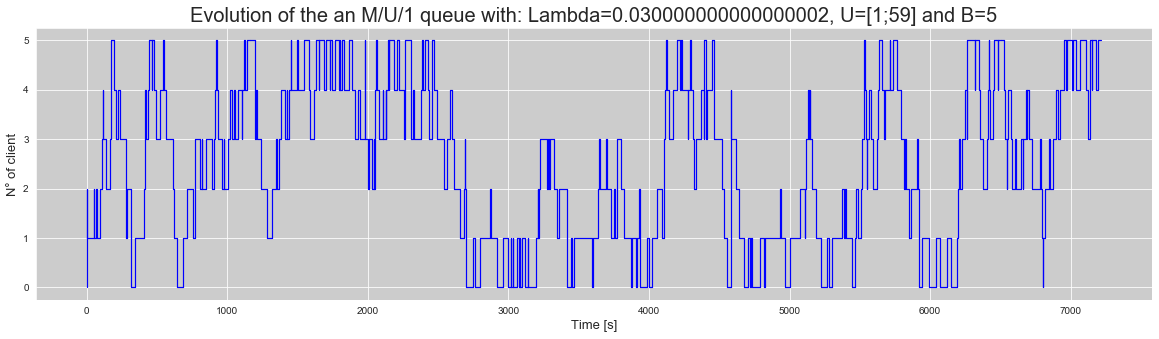

In [ ]:
#plotting
sns.set_palette("colorblind")        
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})

fig, ax = plt.subplots(figsize=(20,5))
old_c = 0
for c in all_client:  
  ax.plot([c[1],c[2]], [c[0],c[0]], linewidth=1.2, c='b')
  ax.plot([c[1],c[1]], [old_c, c[0]], linewidth=1.2, c='b')
  old_c = c[0]

ax.set_xlabel("Time [s]", fontsize=13)
ax.set_ylabel("N° of client", fontsize=13) 
plt.title(f"Evolution of the an M/U/1 queue with: Lambda={l}, U=[{a};{b}] and B={B}", fontsize=20)
plt.show()

##Ploatting

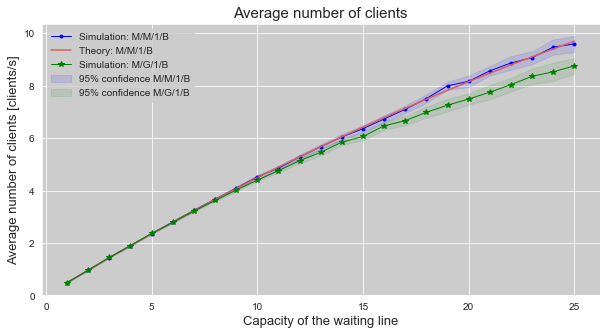

In [ ]:
#average client
#M/M/1/B
LW_ci = []
UP_ci = []
avg_cl, ci_s = mm1b_measure_simulation.get_avg_cl() 
avg_t, _ = mm1b_measure_theory.get_avg_cl()
for i in range(len(ci_s)):
  LW_ci.append(ci_s[i][0])
  UP_ci.append(ci_s[i][1])

sns.set_palette("hls", 8)
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(range(1,Bs), avg_cl, label='Simulation: M/M/1/B', color='b', linewidth=1, alpha = 1, marker='.')
ax.plot(range(1,Bs), avg_t, label ='Theory: M/M/1/B')
ax.fill_between(range(1,Bs), LW_ci, UP_ci, color='b', alpha=.1, label="95% confidence M/M/1/B")

# #M/G/1/B
LW_ci = []
UP_ci = []
avg_cl, ci_s = mg1b_measure_simulation.get_avg_cl() 
for i in range(len(ci_s)):
  LW_ci.append(ci_s[i][0])
  UP_ci.append(ci_s[i][1])

ax.plot(range(1,Bs), avg_cl, label='Simulation: M/G/1/B',linewidth=1, color='g', alpha = 1, marker='*')
ax.fill_between(range(1,Bs), LW_ci, UP_ci, color='g', alpha=.1, label="95% confidence M/G/1/B")

ax.set_ylim(ymin=0)
ax.set_xlabel("Capacity of the waiting line", fontsize=13)
ax.set_ylabel("Average number of clients [clients/s]", fontsize=13)
ax.legend()
plt.title(f"Average number of clients", fontsize=15)
plt.show()

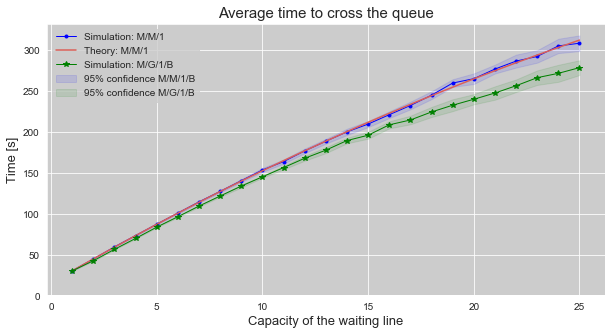

In [ ]:
#average time
LW_ci = []
UP_ci = []
avg_cl, ci_s = mm1b_measure_simulation.get_avg_time() 
avg_t, _ = mm1b_measure_theory.get_avg_time()
for i in range(len(ci_s)):
  LW_ci.append(ci_s[i][0])
  UP_ci.append(ci_s[i][1])

sns.set_palette("hls", 8)
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(range(1,Bs), avg_cl, label='Simulation: M/M/1',linewidth=1, color='b', alpha = 1, marker='.')
ax.plot(range(1,Bs), avg_t, label ='Theory: M/M/1')
ax.fill_between(range(1,Bs), LW_ci, UP_ci, color='b', alpha=.1, label="95% confidence M/M/1/B")

#M/G/1/B
LW_ci = []
UP_ci = []
avg_cl, ci_s = mg1b_measure_simulation.get_avg_time() 
for i in range(len(ci_s)):
  LW_ci.append(ci_s[i][0])
  UP_ci.append(ci_s[i][1])

ax.plot(range(1,Bs), avg_cl, label='Simulation: M/G/1/B', linewidth=1, color='g',  alpha = 1, marker='*')
ax.fill_between(range(1,Bs), LW_ci, UP_ci, color='g', alpha=.1, label="95% confidence M/G/1/B")

ax.set_ylim(ymin=0)
ax.set_xlabel("Capacity of the waiting line", fontsize=13)
ax.set_ylabel("Time [s]", fontsize=13) 
ax.legend()
plt.title(f"Average time to cross the queue", fontsize=15)
plt.show()

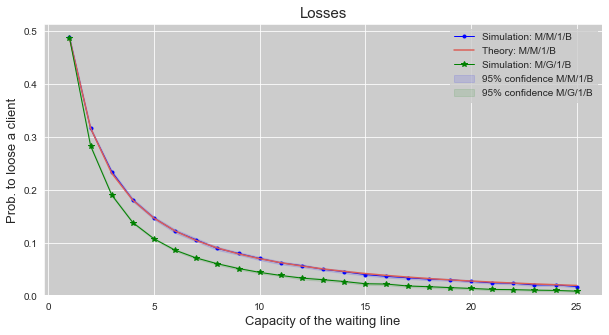

In [ ]:
#Loss
LW_ci = []
UP_ci = []
avg_cl, ci_s = mm1b_measure_simulation.get_loss() 
avg_t, _ = mm1b_measure_theory.get_loss()
for i in range(len(ci_s)):
  LW_ci.append(ci_s[i][0])
  UP_ci.append(ci_s[i][1])

sns.set_palette("hls", 8)
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(range(1,Bs), avg_cl, label='Simulation: M/M/1/B',linewidth=1, color='b', alpha = 1, marker='.')
ax.plot(range(1,Bs), avg_t, label ='Theory: M/M/1/B')
ax.fill_between(range(1,Bs), LW_ci, UP_ci, color='b', alpha=.1, label="95% confidence M/M/1/B")

#M/G/1/B
LW_ci = []
UP_ci = []
avg_cl, ci_s = mg1b_measure_simulation.get_loss() 
for i in range(len(ci_s)):
  LW_ci.append(ci_s[i][0])
  UP_ci.append(ci_s[i][1])

ax.plot(range(1,Bs), avg_cl, label='Simulation: M/G/1/B',linewidth=1, color='g',  alpha = 1, marker='*')
ax.fill_between(range(1,Bs), LW_ci, UP_ci, color='g', alpha=.1, label="95% confidence M/G/1/B")

ax.set_ylim(ymin=0)
ax.set_xlabel("Capacity of the waiting line", fontsize=13)
ax.set_ylabel("Prob. to loose a client", fontsize=13) 
ax.legend()
plt.title(f"Losses", fontsize=15)
plt.show()

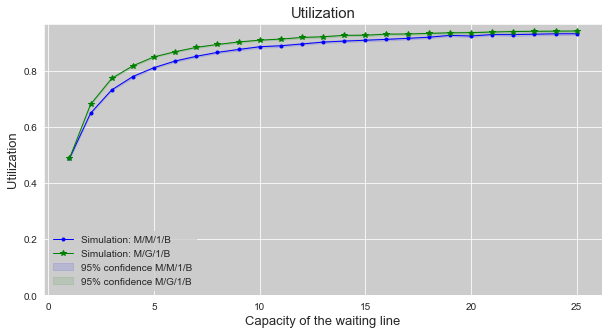

In [ ]:
#average client
#M/M/1/B
LW_ci = []
UP_ci = []
avg_cl, ci_s = mm1b_measure_simulation.get_ut() 
# avg_t, _ = mm1b_measure_theory.get_ut()
for i in range(len(ci_s)):
  LW_ci.append(ci_s[i][0])
  UP_ci.append(ci_s[i][1])

sns.set_palette("hls", 8)
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(range(1,Bs), avg_cl, label='Simulation: M/M/1/B', color='b', linewidth=1, alpha = 1, marker='.')
ax.fill_between(range(1,Bs), LW_ci, UP_ci, color='b', alpha=.1, label="95% confidence M/M/1/B")

# #M/G/1/B
LW_ci = []
UP_ci = []
avg_cl, ci_s = mg1b_measure_simulation.get_ut() 
for i in range(len(ci_s)):
  LW_ci.append(ci_s[i][0])
  UP_ci.append(ci_s[i][1])

ax.plot(range(1,Bs), avg_cl, label='Simulation: M/G/1/B',linewidth=1, color='g', alpha = 1, marker='*')
ax.fill_between(range(1,Bs), LW_ci, UP_ci, color='g', alpha=.1, label="95% confidence M/G/1/B")

ax.set_ylim(ymin=0)
ax.set_xlabel("Capacity of the waiting line", fontsize=13)
ax.set_ylabel("Utilization", fontsize=13) 
ax.legend()
plt.title(f"Utilization", fontsize=15)
plt.show()

#Task3 M/M/m/B queue

In [ ]:
#add the ID and the state to the Client class
class Client:
  def __init__(self, id=-1, arrival_time=0):
    if id == -1:
      print("Error: miss the ID for the client")
    
    self.id = id
    self.arrival_time = arrival_time
    self.depart_time = -1
    self.state = 0   #0 -> in waiting line
                     #1 -> in service

  def served(self, depart_time):  #set the depart time
    self.depart_time = depart_time
    return
  
  def get_arrival_time(self):
    return self.arrival_time

  def get_depart_time(self):
    return self.depart_time
  
  def get_id(self):
    return self.id
  
  def in_service(self): #set the client in service
    self.state = 1
    return
  
  def get_state(self):  #return the actual state of the client
    return self.state

In [ ]:
#re-define the class Server to add new methods
class Server():
  def __init__(self,  id=-1, mu=-1, type_s='M', a=-1, b=-1):
    if type_s == 'M':
      if mu<= 0: 
        print("Wrong parameter!")
        return
      self.mu = mu  #mu for the service rate
    elif type_s == 'U':
      if b<=a:
        print("Wrong interval!")
        return
      self.a = a   #parameter for the uniform distributions
      self.b = b
    else:
      print('Error wrong type of service rate')
      return

    self.type_s = type_s
    self.id = id
    self.N_served = 0 #count of people served by that server
    self.state = 0    #0 -> idle
                      #1 -> busy

  def get_N_served(self):
    return self.N_served

  def free_server(self): #set the server to the idle state
    self.state = 0
    return
  
  def get_id(self):
    return self.id

  def clear_server(self):  #reset the values to 0
    self.state = 0
    self.N_served = 0
    return

  def get_speed(self):
    if self.type_s == 'M':
      return self.mu
    elif type_s == 'U':
      return 1/((self.a + self.b)/2)

  def get_server_state(self):
    return self.state

  def serve(self, time, FES, client_id):  
    self.N_served += 1
    self.state = 1    #set the server to the busy state
  
    if self.type_s == 'M':
      service_time = random.expovariate(self.mu)
    elif self.type_s == 'U':
      service_time = random.uniform(self.a, self.b)

    FES.put((time + service_time, self.id, client_id, "D")) #add a departure in the FES
    return service_time

In [ ]:
#redefine the class queue to manage the removal of the client
class My_queue():
  def __init__(self, type_a='', l=-1, a=-1, b=-1, B=5): 
    self.N_arr = 0
    self.N_dep = 0
    self.oldT = 0
    self.avg_cl = 0
    self.avg_delay = 0
    self.clients = []
    self.N_loss = 0

    if B<= 0:
      print("Wrong value for the  capacity!") 
      return
    self.B = B
    
    if type_a == 'M':
      if l<= 0: 
        print("Wrong parameter!")
        return
      self.l = l  #lambda for the arrival rate
    elif type_a == 'U':
      if b<=a:
        print("Wrong interval!")
        return
      self.a = a   #bound for the uniform distributions
      self.b = b
    else:
      print('Error wrong type of arrival in the queue')
      return
    self.type_a = type_a
  
  def get_N_arr(self):
    return self.N_arr

  def get_N_dep(self):
    return self.N_dep
  
  def get_N_loss(self):
    return self.N_loss

  def get_avg_cl(self, time):
    return self.avg_cl/time

  def arrival(self, time, FES):
    global N_user 
    self.N_arr += 1   #update total number of arrival 
    if len(self.clients) < self.B:
      self.avg_cl += N_user*(time-self.oldT)
      self.oldT = time      #update previous time
      N_user += 1           #update the state variable
      client = Client(self.N_arr, time) #record for the client that arrive in the actual time
      self.clients.append(client) # N_arr will coincide with the client ID
    else: #the client will be not served
      self.N_loss += 1

    if self.type_a == 'M':
      inter_arrival = random.expovariate(self.l)
    elif self.type_a == 'U':
      inter_arrival = random.uniform(self.a, self.b)
    FES.put((time + inter_arrival, -1, -1, "A"))  #Add the next arrival
    return self.N_arr  #return the client id

  def departure(self, time, client_id):
    global N_user 
    #search for the client that must leave the queue
    for i in range(len(self.clients)): 
      if client_id == self.clients[i].get_id():
        client = self.clients.pop(i)
        break

    self.N_dep += 1
    self.avg_cl += N_user*(time-self.oldT)
    self.oldT = time
    client.served(time)
    N_user -= 1  #update the state variable
    return client
  
  def get_next_client(self): #find who is the next client to serve
    for client in self.clients:  #the client list is ordered
      if client.get_state() == 0: #the first client that arrive in the queue and is not in service
        return client.get_id()

  def set_in_service(self, client_id): #set the client state to: in service
    for client in self.clients: 
      if client.get_id() == client_id:
        client.in_service()
    return

In [ ]:
def simulate(Max_time=100, type_a='M', l=0, a_q=0, b_q=0, B=5, servers = [], policy=None):
  global N_user 
  N_user = 0 #state variable
  old_N_user = N_user  #to manage the case B = 1
  time = 0
  N_in_service = 0  #number of people in service = number of server busy
  old_time = time
  ut = 0     #utilization = mean number of server busy
  avg_delay = 0   #average tyme to cross the queue
  FES = PriorityQueue() # Future Event Set
  FES.put((0, -1, -1, "A")) #first event
  N_server = len(servers) 
  if N_server <= 0:
    print("wrong number of server")
    return
  my_queue = My_queue(l=l, type_a=type_a, a=a_q, b=b_q, B=B)

  while time < Max_time:
    (time, server_id, client_id, event_type) = FES.get()
    ut += N_in_service*(time-old_time)  #mean number of server busy in time
    old_time = time
    if event_type == "A":
      old_N_user = N_user
      new_client_id = my_queue.arrival(time,FES)
      new_server_id = policy(servers) #apply the policy
      if new_server_id != -1 and old_N_user != N_user: #at least one server is idle
        servers[new_server_id].serve(time, FES, new_client_id) #schedule the next departure event
        my_queue.set_in_service(new_client_id)  #set the client in sevice
        N_in_service += 1

    elif event_type == "D":
      client = my_queue.departure(time, client_id)
      servers[server_id].free_server()  #now this server is idle
      N_in_service -= 1   # now at least one server is idle
      avg_delay += (client.get_depart_time()-client.get_arrival_time())
      if N_user-N_in_service > 0: # at least 1 client is not in service
        new_server_id = policy(servers)  #apply here the policy
        new_client_id = my_queue.get_next_client()  #get the id of the next client to serve
        servers[new_server_id].serve(time, FES, new_client_id) #schedule the next departure event
        my_queue.set_in_service(new_client_id)  #set the client in sevice
        N_in_service += 1

  #compute indices
  avg_cl = my_queue.get_avg_cl(time)
  avg_delay = avg_delay/my_queue.get_N_dep()
  ut = ut/time  
  los = my_queue.get_N_loss()
  arr = my_queue.get_N_arr()
  L = los/arr
  return avg_cl, avg_delay, ut, L

##Policy

In [ ]:
def next_free(servers):
  s_id = -1
  for s in servers:
    if s.get_server_state() == 0:
      return s.get_id()

  return s_id

In [ ]:
def least_used(servers):
  min_served = np.power(2,30)
  min_id = -1
  for s in servers:
    client_served = s.get_N_served()
    if (client_served < min_served) and (s.get_server_state()==0):
      min_served = client_served
      min_id = s.get_id()

  return min_id

In [ ]:
def fastest(servers):
  fast_id = -1
  max_speed = -1
  for s in servers:
    speed = s.get_speed()
    if (speed > max_speed) and (s.get_server_state()==0):
      max_speed = speed
      fast_id = s.get_id()

  return fast_id

##All the servers with the same capacity

In [ ]:
N_runs = 15  #Number of runs
seed = 1   #initial seed
cl = 0.95  #confidence level

Max_time = 604800   #one week
LOADS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.925, 0.95, 0.975, 0.99]
avg_service_time = 30
mu = 1/avg_service_time   #mu for the service time
B = 10                   #length of the waiting line
mmmb_measure_simulation = [] #Measure_plot() array

N_server = 6
policy = next_free
for i in range(1, N_server):
  mmmb_measure_simulation.append(Measure_plot())

In [ ]:
print("Simulate for the M/M/m/B queue")
for m in range(1, N_server):
  print(f"Number of server: {m}")
  servers = []
  for c in range(m): #all the server with the same capacity
    servers.append(Server(id=c , mu=mu))

  for load in LOADS:
    print(f"The load is: {load}")
    l = (m*load)/avg_service_time   #arrival rate 
    Avg_N_clients = []
    Avg_delay = []
    Utilizations = []
    Loss = []
    for i in range(N_runs):
      print(f'Run number: {i}')
      random.seed(seed)
      avg_cl, avg_d, ut, L = simulate(Max_time=Max_time, type_a='M', l=l, B=B, servers=servers, policy = policy)
      Avg_N_clients.append(avg_cl)
      Avg_delay.append(avg_d)
      Utilizations.append(ut)
      Loss.append(L)
      seed += 1
      for j in range(m): 
        servers[j].clear_server()
    
    ci_avg_cl, avg_cl = conf_int(Avg_N_clients, cl, N_runs)
    mmmb_measure_simulation[m-1].set_avg_cl(avg_cl, ci_avg_cl)

    ci_avg_d, avg_d = conf_int(Avg_delay, cl, N_runs)
    mmmb_measure_simulation[m-1].set_avg_time(avg_d, ci_avg_d)

    ci_ut, ut = conf_int(Utilizations, cl, N_runs)
    mmmb_measure_simulation[m-1].set_ut(ut, ci_ut)

    ci_L, L = conf_int(Loss, cl, N_runs)
    mmmb_measure_simulation[m-1].set_loss(L, ci_L)


Simulate for the M/M/m/B queue
Number of server: 1
The load is: 0.1
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
The load is: 0.2
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
The load is: 0.3
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
The load is: 0.4
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
The load is: 0.5
Run 

In [ ]:
#one single run
global N_user 
N_user = 0  #state variable
old_N_user = N_user
time = 0    #initil time
old_time = time
free_time = 0

load = 0.95
N_server = 4
servers = []
for i in range(N_server): #all the server with the same capacity
  servers.append(Server(id=i , mu=mu))

avg_service_time = 30
l = (N_server*load)/avg_service_time #lambda for the arrival process
mu = 1/avg_service_time   #mu for the service time
B = 10
my_queue = My_queue(l=l, type_a='M', B=B)
policy = next_free
all_client = []
FES = PriorityQueue() # Future Event Set
FES.put((0, -1, -1, "A")) # first event
Max_time = 1400
avg_delay = 0
oldT = 0
N_in_service = 0
ut = 0

In [ ]:
random.seed(1)
while time < Max_time:
  (time, server_id, client_id, event_type) = FES.get()
  ut += N_in_service*(time-old_time)
  old_time = time
  if event_type == "A":
    old_N_user = N_user
    new_client_id = my_queue.arrival(time,FES)
    new_server_id = policy(servers) #apply the policy
    if new_server_id != -1 and old_N_user != N_user: #at least one server is idle
      servers[new_server_id].serve(time, FES, new_client_id)  #create the new departure event
      my_queue.set_in_service(new_client_id)   #set the client in sevice
      N_in_service += 1

  elif event_type == "D":
    client = my_queue.departure(time, client_id)
    servers[server_id].free_server()  #now this server is idle
    N_in_service -= 1   # now at least one server is idle
    avg_delay += (client.get_depart_time()-client.get_arrival_time())
    if N_user-N_in_service > 0: # at least 1 client is not in service
      new_server_id = policy(servers)  #apply here the policy
      new_client_id = my_queue.get_next_client()  #get the id of the next client to serve
      servers[new_server_id].serve(time, FES, new_client_id)  #create the new departure event
      my_queue.set_in_service(new_client_id) #set the client in service
      N_in_service += 1

  all_client.append((N_user,oldT,time)) 
  oldT = time

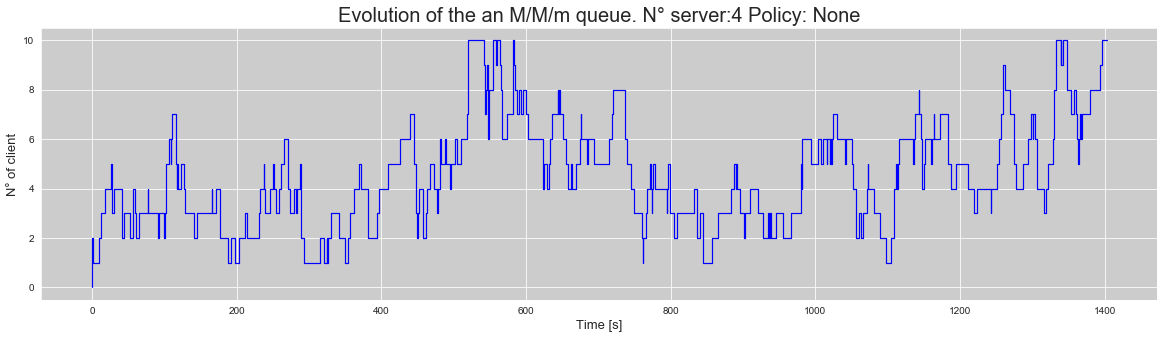

In [ ]:
#plotting
sns.set_palette("colorblind")  #cambiare palette colori
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})

fig, ax = plt.subplots(figsize=(20,5))
old_c = 0
for c in all_client:
  ax.plot([c[1],c[2]], [c[0],c[0]], linewidth=1.2, c='b')
  ax.plot([c[1],c[1]], [old_c, c[0]], linewidth=1.2, c='b')#, label='qui')
  old_c = c[0]

ax.set_xlabel("Time [s]", fontsize=13)
ax.set_ylabel("N° of client", fontsize=13) 
plt.title(f"Evolution of the an M/M/m queue. N° server:{N_server} Policy: None", fontsize=20) 
plt.show()

##Plotting

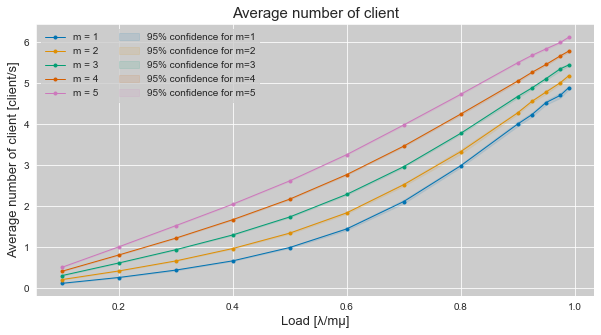

In [ ]:
#average client
#M/M/m/B
N_server = 6
pal = sns.color_palette("colorblind").as_hex() 
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})
fig, ax = plt.subplots(figsize=(10,5))

for m in range(1, N_server):
  LW_ci = []
  UP_ci = []
  avg_cl, ci_s = mmmb_measure_simulation[m-1].get_avg_cl() 
  for i in range(len(ci_s)):
    LW_ci.append(ci_s[i][0])
    UP_ci.append(ci_s[i][1])

  ax.plot(LOADS, avg_cl, label= f'm = {m}', linewidth=1, alpha = 1, marker='.', color=pal[m-1])
  ax.fill_between(LOADS, LW_ci, UP_ci, alpha=.1, label=f"95% confidence for m={m}", color=pal[m-1])

ax.set_xlabel("Load [\u03BB/m\u03BC]", fontsize=13)
ax.set_ylabel("Average number of client [client/s]", fontsize=13) 
ax.legend(ncol=2)
plt.title(f"Average number of client", fontsize=15)
plt.show()

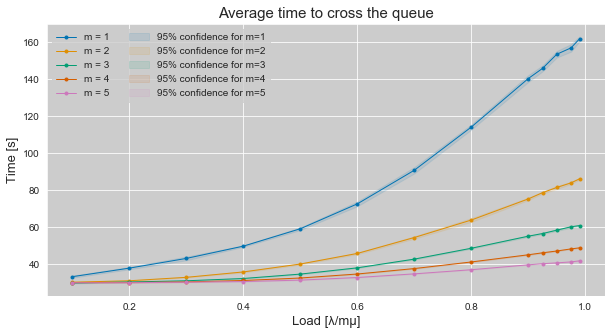

In [ ]:
#average time
#M/M/m/B
pal = sns.color_palette("colorblind").as_hex() 
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})
fig, ax = plt.subplots(figsize=(10,5))

for m in range(1, N_server):
  LW_ci = []
  UP_ci = []
  avg_cl, ci_s = mmmb_measure_simulation[m-1].get_avg_time() 
  for i in range(len(ci_s)):
    LW_ci.append(ci_s[i][0])
    UP_ci.append(ci_s[i][1])

  ax.plot(LOADS, avg_cl, label= f'm = {m}', linewidth=1, alpha = 1, marker='.', color=pal[m-1])
  ax.fill_between(LOADS, LW_ci, UP_ci, alpha=.1, label=f"95% confidence for m={m}", color=pal[m-1])

ax.set_xlabel("Load [\u03BB/m\u03BC]", fontsize=13)
ax.set_ylabel("Time [s]", fontsize=13) 
ax.legend(ncol=2)
plt.title(f"Average time to cross the queue", fontsize=15)
plt.show()

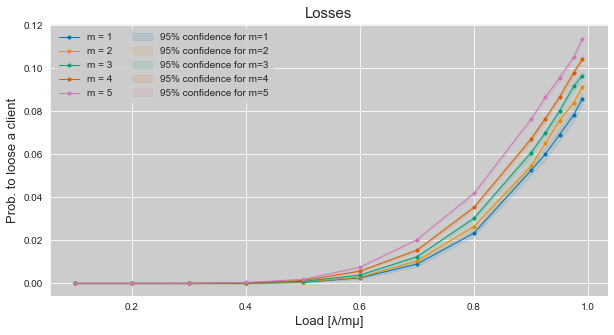

In [ ]:
#Losses
#M/M/m/B
pal = sns.color_palette("colorblind").as_hex() 
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})
fig, ax = plt.subplots(figsize=(10,5))

for m in range(1, N_server):
  LW_ci = []
  UP_ci = []
  avg_cl, ci_s = mmmb_measure_simulation[m-1].get_loss() 
  for i in range(len(ci_s)):
    LW_ci.append(ci_s[i][0])
    UP_ci.append(ci_s[i][1])

  ax.plot(LOADS, avg_cl, label= f'm = {m}', linewidth=1, alpha = 1, marker='.', color=pal[m-1])
  ax.fill_between(LOADS, LW_ci, UP_ci, alpha=.1, label=f"95% confidence for m={m}", color=pal[m-1])

ax.set_xlabel("Load [\u03BB/m\u03BC]", fontsize=13)
ax.set_ylabel("Prob. to loose a client", fontsize=13)
ax.legend(ncol=2)
plt.title(f"Losses", fontsize=15)
plt.show()

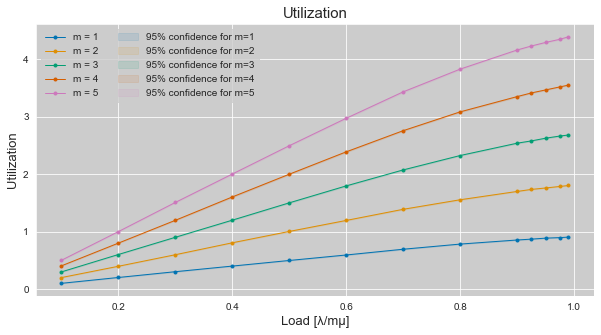

In [ ]:
#Utilization
#M/M/m/B
pal = sns.color_palette("colorblind").as_hex() 
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})
fig, ax = plt.subplots(figsize=(10,5))

for m in range(1, N_server):
  LW_ci = []
  UP_ci = []
  avg_cl, ci_s = mmmb_measure_simulation[m-1].get_ut() 
  for i in range(len(ci_s)):
    LW_ci.append(ci_s[i][0])
    UP_ci.append(ci_s[i][1])

  ax.plot(LOADS, avg_cl, label= f'm = {m}', linewidth=1, alpha = 1, marker='.', color=pal[m-1])
  ax.fill_between(LOADS, LW_ci, UP_ci, alpha=.1, label=f"95% confidence for m={m}", color=pal[m-1])

ax.set_xlabel("Load [\u03BB/m\u03BC]", fontsize=13)
ax.set_ylabel("Utilization", fontsize=13)
ax.legend(ncol=2)
plt.title(f"Utilization", fontsize=15)
plt.show()

##Servers with different capacity

### Policy 1: The least used

In [ ]:
N_runs = 15  #Number of runs
seed = 1   #initial seed
cl = 0.95  #confidence level

Max_time = 604800 #one week
N_server = 3
policy = least_used
servers = []
servers.append(Server(id=0 , mu=1/15))
servers.append(Server(id=1 , mu=1/30))
servers.append(Server(id=2 , mu=1/45))

B=10      #length of the waiting line
LOADS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.925, 0.95, 0.975, 0.99]
mmm_least_used_measure_simulation = Measure_plot()

In [ ]:
print("Simulate M/M/m/B queue with least used policy")
for load in LOADS:
  print(f"load is: {load}")
  l = load*(1/15+1/30+1/45)   #lambda for the arrival process
  seed = 1
  Avg_N_clients = []
  Avg_delay = []
  Utilizations = []
  Loss = []
  for i in range(N_runs):
    print(f'Run number: {i}')
    random.seed(seed)
    avg_cl, avg_d, ut, L = simulate(Max_time=Max_time, type_a='M', l=l, B=B, servers=servers, policy=policy)
    Avg_N_clients.append(avg_cl)
    Avg_delay.append(avg_d)
    Utilizations.append(ut)
    Loss.append(L)
    seed += 1
    for j in range(N_server):
      servers[j].clear_server()

  ci_avg_cl, avg_cl = conf_int(Avg_N_clients, cl, N_runs)
  mmm_least_used_measure_simulation.set_avg_cl(avg_cl, ci_avg_cl)

  ci_avg_d, avg_d = conf_int(Avg_delay, cl, N_runs)
  mmm_least_used_measure_simulation.set_avg_time(avg_d, ci_avg_d)

  ci_ut, ut = conf_int(Utilizations, cl, N_runs)
  mmm_least_used_measure_simulation.set_ut(ut, ci_ut)

  ci_L, L = conf_int(Loss, cl, N_runs)
  mmm_least_used_measure_simulation.set_loss(L, ci_L)

Simulate M/M/m/B queue with least used policy
load is: 0.1
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
load is: 0.2
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
load is: 0.3
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
load is: 0.4
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
load is: 0.5
Run number: 0
Run number: 1
R

In [ ]:
#one single run
global N_user 
N_user = 0  #state variable
old_N_user = N_user
time = 0    #initil time
free_time = 0

load = 0.8
avg_service_time = 30
l = load*(1/15+1/30+1/45)   #lambda for the arrival process
B = 10
my_queue = My_queue(l=l, type_a='M', B=B)
servers = []

servers.append(Server(id=0 , mu=1/15))
servers.append(Server(id=1 , mu=1/30))
servers.append(Server(id=2 , mu=1/45))

policy = least_used
all_client = []
FES = PriorityQueue() # Future Event Set
FES.put((0, -1, -1, "A")) #first event
Max_time = 1400 #2 hours
avg_delay = 0
oldT = 0
N_in_service = 0
ut = 0
old_time = 0

In [ ]:
random.seed(1)
while time < Max_time:
  (time, server_id, client_id, event_type) = FES.get()
  ut += N_in_service*(time-old_time)
  old_time = time
  if event_type == "A":
    old_N_user = N_user
    new_client_id = my_queue.arrival(time,FES)
    new_server_id = policy(servers) #apply the policy
    if new_server_id != -1 and old_N_user != N_user: #at least one server is idle
      servers[new_server_id].serve(time, FES, new_client_id) 
      my_queue.set_in_service(new_client_id)
      N_in_service += 1

  elif event_type == "D":
    client = my_queue.departure(time, client_id)
    servers[server_id].free_server()  #now this server is idle
    N_in_service -= 1   # now at least one server is idle
    avg_delay += (client.get_depart_time()-client.get_arrival_time())
    if N_user-N_in_service > 0: # at least 1 client is not in service
      new_server_id = policy(servers)  #apply here the policy
      new_client_id = my_queue.get_next_client()
      servers[new_server_id].serve(time, FES, new_client_id)
      my_queue.set_in_service(new_client_id)
      N_in_service += 1

  all_client.append((N_user,oldT,time)) 
  oldT = time

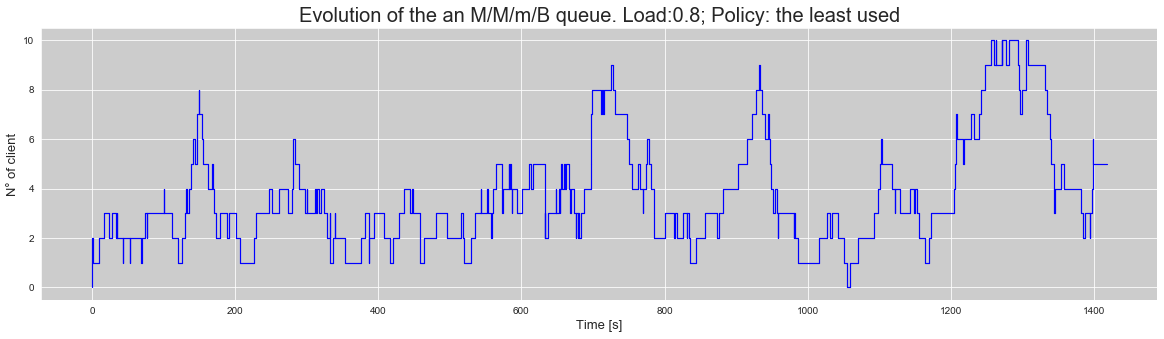

In [ ]:
#plotting
sns.set_palette("colorblind")  #cambiare palette colori
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})

fig, ax = plt.subplots(figsize=(20,5))
old_c = 0
for c in all_client:
  ax.plot([c[1],c[2]], [c[0],c[0]], linewidth=1.2, c='b')
  ax.plot([c[1],c[1]], [old_c, c[0]], linewidth=1.2, c='b')#, label='qui')
  old_c = c[0]

ax.set_xlabel("Time [s]", fontsize=13)
ax.set_ylabel("N° of client", fontsize=13) 
plt.title(f"Evolution of the an M/M/m/B queue. Load:{load}; Policy: the least used", fontsize=20)
plt.show()

###Policy 2: the fastest

In [ ]:
N_runs = 15  #Number of runs
seed = 1   #initial seed
cl = 0.95  #confidence level

Max_time = 604800 #one week
N_server = 3
policy = fastest
servers = []
servers.append(Server(id=0 , mu=1/15))
servers.append(Server(id=1 , mu=1/30))
servers.append(Server(id=2 , mu=1/45))

B=10                  #length of the waiting line
LOADS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.925, 0.95, 0.975, 0.99]
mmm_fastest_measure_simulation = Measure_plot()

In [ ]:
print("Simulate M/M/m/B queue with least used policy")
for load in LOADS:
  print(f"load is: {load}")
  l = load*(1/15+1/30+1/45)   #lambda for the arrival process
  seed = 1
  Avg_N_clients = []
  Avg_delay = []
  Utilizations = []
  Loss = []
  for i in range(N_runs):
    print(f'Run number: {i}')
    random.seed(seed)
    avg_cl, avg_d, ut, L = simulate(Max_time=Max_time, type_a='M', l=l, B=B, servers=servers, policy=policy)
    Avg_N_clients.append(avg_cl)
    Avg_delay.append(avg_d)
    Utilizations.append(ut)
    Loss.append(L)
    seed += 1
    for j in range(N_server):
      servers[j].clear_server()

  ci_avg_cl, avg_cl = conf_int(Avg_N_clients, cl, N_runs)
  mmm_fastest_measure_simulation.set_avg_cl(avg_cl, ci_avg_cl)

  ci_avg_d, avg_d = conf_int(Avg_delay, cl, N_runs)
  mmm_fastest_measure_simulation.set_avg_time(avg_d, ci_avg_d)

  ci_ut, ut = conf_int(Utilizations, cl, N_runs)
  mmm_fastest_measure_simulation.set_ut(ut, ci_ut)

  ci_L, L = conf_int(Loss, cl, N_runs)
  mmm_fastest_measure_simulation.set_loss(L, ci_L)

Simulate M/M/m/B queue with least used policy
load is: 0.1
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
load is: 0.2
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
load is: 0.3
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
load is: 0.4
Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
Run number: 5
Run number: 6
Run number: 7
Run number: 8
Run number: 9
Run number: 10
Run number: 11
Run number: 12
Run number: 13
Run number: 14
load is: 0.5
Run number: 0
Run number: 1
R

In [ ]:
# one single run
global N_user 
N_user = 0  #state variable
old_N_user = N_user
time = 0    #initil time
free_time = 0

load = 0.8
l = load*(1/15+1/30+1/45)   #lambda for the arrival process
B = 10
my_queue = My_queue(l=l, type_a='M', B=B)
servers = []

servers.append(Server(id=0 , mu=1/15))
servers.append(Server(id=1 , mu=1/30))
servers.append(Server(id=2 , mu=1/45))

policy = fastest

all_client = []
FES = PriorityQueue() # Future Event Set
FES.put((0, -1, -1, "A")) #first event
Max_time = 1400
avg_delay = 0
oldT = 0
N_in_service = 0

In [ ]:
random.seed(1)
while time < Max_time:
  (time, server_id, client_id, event_type) = FES.get()
  ut += N_in_service*(time-old_time)
  old_time = time
  if event_type == "A":
    old_N_user = N_user
    new_client_id = my_queue.arrival(time,FES)
    new_server_id = policy(servers) #apply the policy
    if new_server_id != -1 and old_N_user != N_user: #at least one server is idle
      servers[new_server_id].serve(time, FES, new_client_id) 
      my_queue.set_in_service(new_client_id)
      N_in_service += 1

  elif event_type == "D":
    client = my_queue.departure(time, client_id)
    servers[server_id].free_server()  #now this server is idle
    N_in_service -= 1   # now at least one server is idle
    avg_delay += (client.get_depart_time()-client.get_arrival_time())
    if N_user-N_in_service > 0: # at least 1 client is not in service
      new_server_id = policy(servers)  #apply here the policy
      new_client_id = my_queue.get_next_client()
      servers[new_server_id].serve(time, FES, new_client_id)
      my_queue.set_in_service(new_client_id)
      N_in_service += 1

  all_client.append((N_user,oldT,time)) 
  oldT = time

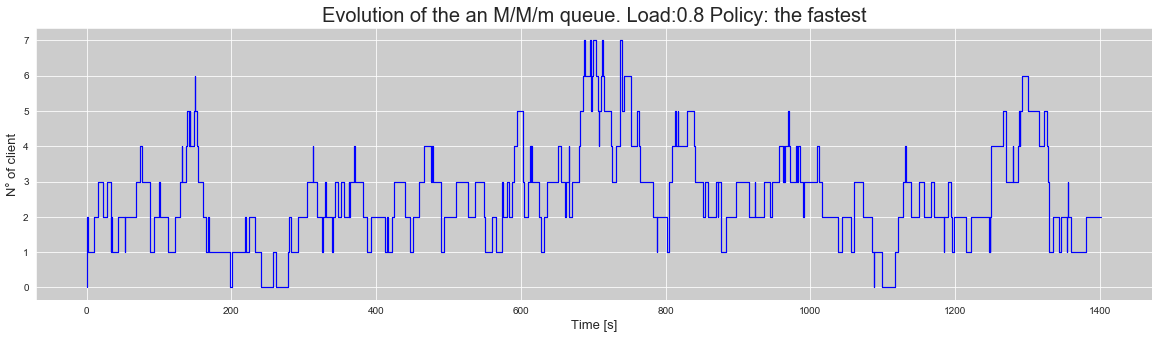

In [ ]:
#plotting
sns.set_palette("colorblind") 
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})

fig, ax = plt.subplots(figsize=(20,5))
old_c = 0
for c in all_client:
  ax.plot([c[1],c[2]], [c[0],c[0]], linewidth=1.2, c='b')
  ax.plot([c[1],c[1]], [old_c, c[0]], linewidth=1.2, c='b')
  old_c = c[0]

ax.set_xlabel("Time [s]", fontsize=13)
ax.set_ylabel("N° of client", fontsize=13) 
plt.title(f"Evolution of the an M/M/m queue. Load:{load} Policy: the fastest", fontsize=20)
plt.show()

###Plotting

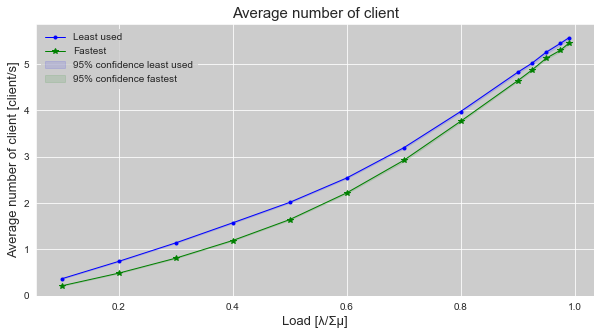

In [ ]:
#average client
#M/M/m/B the least used
LW_ci = []
UP_ci = []
avg_cl, ci_s = mmm_least_used_measure_simulation.get_avg_cl() 
for i in range(len(ci_s)):
  LW_ci.append(ci_s[i][0])
  UP_ci.append(ci_s[i][1])

sns.set_palette("hls", 8)
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(LOADS, avg_cl, label='Least used', color='b', linewidth=1, alpha = 1, marker='.')
ax.fill_between(LOADS, LW_ci, UP_ci, color='b', alpha=.1, label="95% confidence least used")

# #M/M/m/B the fastest
LW_ci = []
UP_ci = []
avg_cl, ci_s = mmm_fastest_measure_simulation.get_avg_cl() 
for i in range(len(ci_s)):
  LW_ci.append(ci_s[i][0])
  UP_ci.append(ci_s[i][1])

ax.plot(LOADS, avg_cl, label='Fastest',linewidth=1, color='g', alpha = 1, marker='*')
ax.fill_between(LOADS, LW_ci, UP_ci, color='g', alpha=.1, label="95% confidence fastest")

ax.set_ylim(ymin=0)
ax.set_xlabel("Load [\u03BB/\u03A3\u03BC]", fontsize=13)
ax.set_ylabel("Average number of client [client/s]", fontsize=13)
ax.legend()
plt.title(f"Average number of client", fontsize=15)
plt.show()

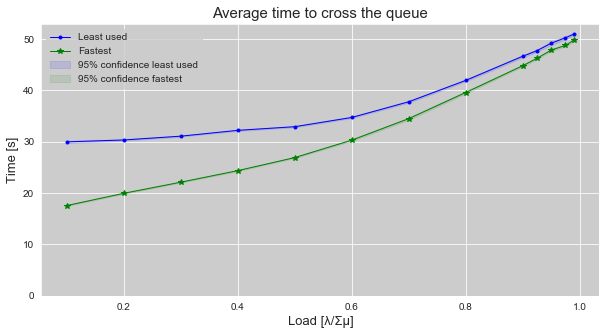

In [ ]:
#average time
#M/M/m/B the least used
LW_ci = []
UP_ci = []
avg_cl, ci_s = mmm_least_used_measure_simulation.get_avg_time() 
for i in range(len(ci_s)):
  LW_ci.append(ci_s[i][0])
  UP_ci.append(ci_s[i][1])

sns.set_palette("hls", 8)
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(LOADS, avg_cl, label='Least used', color='b', linewidth=1, alpha = 1, marker='.')
ax.fill_between(LOADS, LW_ci, UP_ci, color='b', alpha=.1, label="95% confidence least used")

# #M/M/m/B the fastest
LW_ci = []
UP_ci = []
avg_cl, ci_s = mmm_fastest_measure_simulation.get_avg_time() 
for i in range(len(ci_s)):
  LW_ci.append(ci_s[i][0])
  UP_ci.append(ci_s[i][1])

ax.plot(LOADS, avg_cl, label='Fastest',linewidth=1, color='g', alpha = 1, marker='*')
ax.fill_between(LOADS, LW_ci, UP_ci, color='g', alpha=.1, label="95% confidence fastest")

ax.set_ylim(ymin=0)
ax.set_xlabel("Load [\u03BB/\u03A3\u03BC]", fontsize=13)
ax.set_ylabel("Time [s]", fontsize=13) 
ax.legend()
plt.title(f"Average time to cross the queue", fontsize=15)
plt.show()

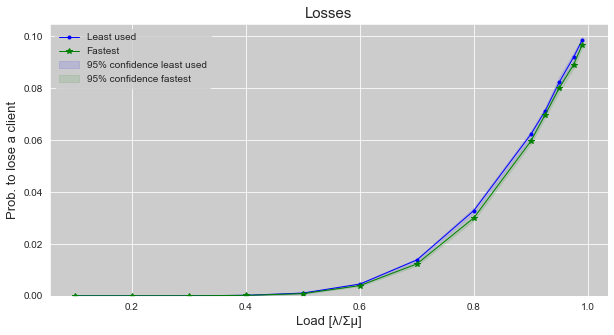

In [ ]:
#losses
#M/M/m/B the least used
LW_ci = []
UP_ci = []
avg_cl, ci_s = mmm_least_used_measure_simulation.get_loss() 
for i in range(len(ci_s)):
  LW_ci.append(ci_s[i][0])
  UP_ci.append(ci_s[i][1])

sns.set_palette("hls", 8)
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(LOADS, avg_cl, label='Least used', color='b', linewidth=1, alpha = 1, marker='.')
ax.fill_between(LOADS, LW_ci, UP_ci, color='b', alpha=.1, label="95% confidence least used")

# #M/M/m/B the fastest
LW_ci = []
UP_ci = []
avg_cl, ci_s = mmm_fastest_measure_simulation.get_loss() 
for i in range(len(ci_s)):
  LW_ci.append(ci_s[i][0])
  UP_ci.append(ci_s[i][1])

ax.plot(LOADS, avg_cl, label='Fastest',linewidth=1, color='g', alpha = 1, marker='*')
ax.fill_between(LOADS, LW_ci, UP_ci, color='g', alpha=.1, label="95% confidence fastest")

ax.set_ylim(ymin=0)
ax.set_xlabel("Load [\u03BB/\u03A3\u03BC]", fontsize=13)
ax.set_ylabel("Prob. to lose a client", fontsize=13) 
ax.legend()
plt.title(f"Losses", fontsize=15)
plt.show()

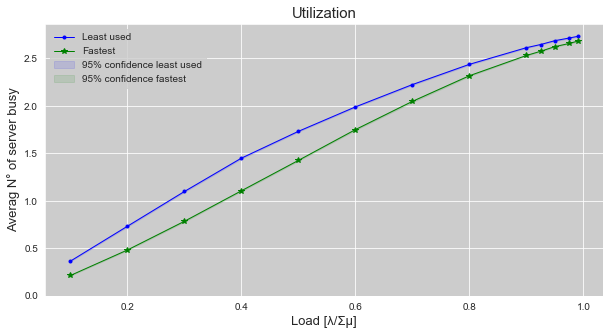

In [ ]:
#utilization
#M/M/m/B the least used
LW_ci = []
UP_ci = []
avg_cl, ci_s = mmm_least_used_measure_simulation.get_ut() 
for i in range(len(ci_s)):
  LW_ci.append(ci_s[i][0])
  UP_ci.append(ci_s[i][1])

sns.set_palette("hls", 8)
sns.set_style("darkgrid", {"axes.facecolor": "0.8"})
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(LOADS, avg_cl, label='Least used', color='b', linewidth=1, alpha = 1, marker='.')
ax.fill_between(LOADS, LW_ci, UP_ci, color='b', alpha=.1, label="95% confidence least used")

# #M/M/m/B the fastest
LW_ci = []
UP_ci = []
avg_cl, ci_s = mmm_fastest_measure_simulation.get_ut() 
for i in range(len(ci_s)):
  LW_ci.append(ci_s[i][0])
  UP_ci.append(ci_s[i][1])

ax.plot(LOADS, avg_cl, label='Fastest',linewidth=1, color='g', alpha = 1, marker='*')
ax.fill_between(LOADS, LW_ci, UP_ci, color='g', alpha=.1, label="95% confidence fastest")

ax.set_ylim(ymin=0)
ax.set_xlabel("Load [\u03BB/\u03A3\u03BC]", fontsize=13)
ax.set_ylabel("Averag N° of server busy", fontsize=13) 
ax.legend()
plt.title(f"Utilization", fontsize=15)
plt.show()